Import libraries

In [276]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torchmetrics.classification import MulticlassAccuracy
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe

Create tokenizer object (to convert tweets to tokens). Get the pre-trained word embeddings from GloVe

In [264]:
tokenizer = get_tokenizer('basic_english')
glove = GloVe(name='6B', dim=100)

Function to clean out tweets dataset

In [265]:
def clean_out_data(original_df, desired_columns_list):
    """ Reduces data columns to desired column list
        Modifies polarity values (negative sentiment: 0, positive sentiment: 1)
    Args:
        original_df: pandas dataframe
        desired_columns_list: list containing the desired columns to keep
    """
    df = original_df.copy()
    df = df[desired_columns_list]
    df.loc[:, 'polarity'] = df['polarity'].replace({0: 0, 4: 1})
    return df

Load the dataset. Create train (70%), validation (15%), and test (15%) datasets

Dataset is a part of Stanford Sentiment140 dataset (http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip)

In [266]:
# Load the dataset and split into train validation test
dataset_df = pd.read_csv("trainingandtestdata/training.1600000.processed.noemoticon.csv", encoding='latin1', header=None)
dataset_df = dataset_df.sample(n=20000)
dataset_df.columns = ['polarity', 'id', 'date', 'query', 'user', 'tweet']

train_df, validation_test_df = train_test_split(dataset_df, test_size=0.3)
validation_df, test_df = train_test_split(validation_test_df, test_size=0.5)

train_df = clean_out_data(train_df, ['tweet', 'polarity'])
validation_df = clean_out_data(validation_df, ['tweet', 'polarity'])
test_df = clean_out_data(test_df, ['tweet', 'polarity'])

In [267]:
def process_tweets(df):
    """ Tokenizes tweets then stack them as tensors
    Args:
        df: pandas dataframe
    Returns:
        tuple (list, tensor): a list of stacked word embeddings, corresponding labels tensor
    """
    tweets_list, labels_list = [], []
    for idx, row in df.iterrows():
        tweet, label = row['tweet'], row['polarity']
        tokens = tokenizer(tweet)
        tweet_embeddings = [glove[word] for word in tokens if word in glove.stoi]
        if tweet_embeddings and label in [0, 1]:
            tweets_list.append(torch.stack(tweet_embeddings))
            labels_list.append(label)
    return tweets_list, torch.tensor(labels_list, dtype=torch.int64)

Process tweets by Tokenizing them each tweet then stacking them as tensors

Pad the processed tweets and adding zeros so that all tensors in each data group (train, test, validation) are of the same size.

In [268]:
train_data, train_data_labels = process_tweets(train_df)
validation_data, validation_data_labels = process_tweets(validation_df)
test_data, test_data_labels = process_tweets(test_df)

# Padding train, test, validation datasets by adding zeros
train_data = pad_sequence(train_data, batch_first = True, padding_value= 0)
validation_data = pad_sequence(validation_data, batch_first = True, padding_value= 0)
test_data = pad_sequence(test_data, batch_first = True, padding_value= 0)

In [269]:
class Tweet_SentimentClassifier(nn.Module):
    """ Class with the 1D convolutional NN structure, and includes train and predict methods
    """
    def __init__(self, input_size, hidden_size, output_size, kernel_size=5):
        nn.Module.__init__(self)
        self.conv = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=kernel_size, padding=kernel_size//2)
        self.linear = nn.Linear(input_size, output_size)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()  # ReLU activation function

    
    def forward(self, input):
        """ NN forward pass
        Args:
            input: tensor of shape (batch_size, input_size)
        Returns:
            output: tensor of shape (batch_size, output_size)
        """
        input = input.permute(0, 2, 1)  # (batch_size, embedding_size, seq_len)
        conv_out = self.conv(input)
        conv_out = self.relu(conv_out)
        pooled_out, _ = torch.max(conv_out, dim=2)  # max pooling
        pooled_out = self.dropout(pooled_out) # dropout to avoid overfitting
        output = self.linear(pooled_out)
        return output


    def _moving_average(self,losses, window):
        """ Compute a simple moving average over the loss values """
        return np.convolve(losses, np.ones(window)/window, mode='valid')

        
    def train_model(self, train_input_tensor, train_labels,validation_input_tensor, validation_labels, loss_function, optimizer, epochs, validation_loss_smoothing_window, epochs_without_improvement_threshold):
        """ Trains the model
        Args:
            input_tensors: input tensor of shape (batch_size, input_size)
            labels: label tensor of shape (batch_size, output_size)
            validation_input_tensor: validation data tensor of shape (batch_size, input_size)
            validation_labels: validation label tensor of shape (batch_size, output_size)
            loss_function: loss function (e.g., cross entropy loss)
            optimizer: the optimizer (e.g., Adam)
            epochs: number of epochs
            validation_loss_smoothing_window: validation loss smoothing window
            epochs_without_improvement_threshold: Maximum allowed consequent epochs without validation loss improvement
        Returns:
            None
        """
        # Line objects for train and validation loss
        train_line, = ax.plot([], [], label='Train Loss', color='b')
        val_line, = ax.plot([], [], label='Validation Loss', color='r')
        ax.legend()

        
        best_validation_loss = float('inf')
        epochs_without_improvement = 0
        train_loss_list = []
        validation_loss_list = []
        for epoch in range(epochs):
            self.train()
            output = self(train_input_tensor)
            loss = loss_function(output, train_labels)
            train_loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, validation_loss = self.predict(validation_input_tensor, validation_labels)
            validation_loss_list.append(validation_loss.item())

            # Monitoring smoothed validation loss and potentially stop the training to avoid overfitting
            smoothed_validation_loss = self._moving_average(validation_loss_list, validation_loss_smoothing_window)
            if epoch<validation_loss_smoothing_window:
                pass
            elif smoothed_validation_loss[-1] < best_validation_loss:
                best_validation_loss = smoothed_validation_loss[-1]
                epochs_without_improvement = 0  # Reset the counter when validation loss improves
            else:
                epochs_without_improvement += 1
            
            # Stop if smoothed validation loss starts increasing while training loss is still decreasing
            if epochs_without_improvement > epochs_without_improvement_threshold:
                print(f"Stopping at epoch {epoch + 1} due to no improvement in smoothed validation loss.")
                break

            if (epoch+1)%10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.6f}, Validation Loss: {validation_loss.item():.6f}")
        
        # Plot the train and validation loss
        plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, color='red', label="train loss")
        plt.plot(range(1, len(validation_loss_list) + 1), validation_loss_list, color='blue', label="validation loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.show()

    
    def predict(self, input_tensor, actual_labels):
        """ Predicts labels
        Args:
            input_tensor: input tensor of shape (batch_size, input_size)
        Returns:
            tuple(predicted_labels, loss): predicted labels of shape (batch_size, output_size), loss
        """
        self.eval()
        with torch.no_grad():
            predictions = self(input_tensor).squeeze()
            loss = loss_function(predictions, actual_labels)
            predicted_labels = torch.argmax(predictions, dim = 1)
        return predicted_labels, loss

Define the tweet classifier object, loss function, and optimizer

In [273]:
tweet_classifier = Tweet_SentimentClassifier(input_size = 100, hidden_size = 100, output_size = 2)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(tweet_classifier.parameters(), lr = 0.001, weight_decay = 0.001)

Train the model and track the train loss and validation loss to avoid overfitting

Epoch [10/500], Training Loss: 0.666011, Validation Loss: 0.655122
Epoch [20/500], Training Loss: 0.620021, Validation Loss: 0.621124
Epoch [30/500], Training Loss: 0.590449, Validation Loss: 0.591847
Epoch [40/500], Training Loss: 0.559723, Validation Loss: 0.568076
Epoch [50/500], Training Loss: 0.535091, Validation Loss: 0.550279
Epoch [60/500], Training Loss: 0.514181, Validation Loss: 0.537924
Epoch [70/500], Training Loss: 0.493877, Validation Loss: 0.528112
Epoch [80/500], Training Loss: 0.477881, Validation Loss: 0.521075
Epoch [90/500], Training Loss: 0.462070, Validation Loss: 0.515595
Epoch [100/500], Training Loss: 0.447814, Validation Loss: 0.511545
Epoch [110/500], Training Loss: 0.434128, Validation Loss: 0.508603
Epoch [120/500], Training Loss: 0.416183, Validation Loss: 0.505922
Epoch [130/500], Training Loss: 0.400803, Validation Loss: 0.505074
Epoch [140/500], Training Loss: 0.390168, Validation Loss: 0.503191
Epoch [150/500], Training Loss: 0.379966, Validation Loss

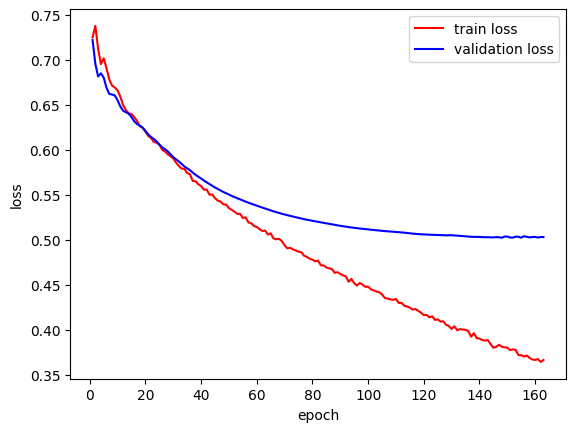

In [274]:
tweet_classifier.train_model(train_data, train_data_labels, validation_data, validation_data_labels, loss_function, optimizer, 500, 10, 10)

Evaluate the trained model using test data by calculating accuracy

In [280]:
calculate_accuracy = MulticlassAccuracy(num_classes = 2)
print("Evaluating test data:")
predicted_test_labels,_ = tweet_classifier.predict(test_data, test_data_labels)
print(f"Accuracy: {calculate_accuracy(predicted_test_labels, test_data_labels)}")

print("Checking model accuracy on train data (overfitting avoided by early stop):")
predicted_train_labels,_ = tweet_classifier.predict(train_data, train_data_labels)
print(f"Accuracy: {calculate_accuracy(predicted_train_labels, train_data_labels)}")

Evaluating test data:
Accuracy: 0.7519570589065552
Checking model accuracy on train data (overfitting avoided by early stop):
Accuracy: 0.8830654621124268
